# Ch04. Gradient Boosting to XGBoost
+ 배깅에서 부스팅까지
+ 그레디언트 부스팅 작동 방식
+ 그레디언트 부스팅 매개변수 튜닝
+ 빅데이터 다루기 - 그레디언트 부스팅 vs XGBoost

## 4.1. 배깅에서 부스팅까지

+ **배깅**은 부트스트랩 샘플을 사용해서, 앙상블 모델 구축
    + 독립적으로 모델들(트리)가 생성되고, 이를 앙상블함
+ **부스팅**은 이전 모델의 오차를 기반으로 새로운 모델을 훈련
    + 이전 모델(트리)에 영향을 받아 하나의 앙상블 모델(트리)가 생성됨
    
**부스팅 알고리즘**
+ 약한 학습기를 강력한 학습기로 변환하는 것이 부스팅 알고리즘의 일반적인 아이디어
+ 부스팅은 강력한 기반 모델을 만드는 것이 아니라, 반복적으로 오류를 고치는 데 초점을 맞춤
    + 기반 모델이 너무 강하면, 학습 과정이 제한되어 부스팅 모델의 전략을 약화시킴

### 4.1.1. 에이다부스트
에이다 부스트는 초기 부스팅 모델 중 하나로 **새로운 트리가 이전 트리의 오차를 기반으로 가중치 조정**
+ 오류 샘플의 가중치를 높여, 잘못된 예측에 더 많은 주의를 기울임
+ 약한 학습기(우연보다 조금 더 나은 성능)을 강력한 학습기(많은 양의 데이터에서 학습하여, 매우 잘 수행되는 모델)로 만듦



**공식문서**
+ https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
+ https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

In [6]:
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
import numpy as np
np.random.seed(42)

# X와 y 생성
X = np.random.rand(500, 5)
y = np.random.rand(500, 1)
y = y.reshape(-1)

model = AdaBoostRegressor(n_estimators=100)
model.fit(X,y)
print(model)

AdaBoostRegressor(n_estimators=100)


### 4.1.2. 그레디언트 부스팅

**에이다부스트와 차이점**
+ 잘못된 예측을 기반으로 조정되는 것은 같지만, 이전 트리의 예츠 오차를 기반으로 **완전히 새로운 트리를 훈련**함
    + 새로운 트리는 올바르게 예측된 값에는 영향을 받지 않음
    
**특징**
+ 각 트리의 예측 값을 더해 모델 평가에 사용
+ 예측 값과 실제 값 사이의 차이인 **잔차**를 활용

## 4.2. 그레디언트 부스팅 작동방식 - 트리로부터 모델구축

In [7]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
xgb.set_config(verbosity=0)

### 4.2.2. 데이터 로드

In [9]:
df_bikes = pd.read_csv('bike_rentals_cleaned.csv')

# 데이터를 X와 y로 나눕니다.
X_bikes = df_bikes.iloc[:,:-1]
y_bikes = df_bikes.iloc[:,-1]


# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, random_state=42)

df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


### 4.2.3. 그레디언트 부스팅 모델 만들기
1. 결정트리 훈련 : `max_depth = 1`인 **스텀프** 또는 `max_depth = 2,3,`으로 사용
    + 부스팅 자체가 기본 학습기에 의존하는 모델이 아니라, 오차에서 학습하는 모델을 원하는 것이기 때문에 **튜닝 하지 않음**

2. 훈련 데이터에 대한 예측 생성

3. 잔차 생성(=새로운 훈련데이터 y)


4. 위의 1~3단계를 반복 (추가할 트리 개수만큼)

5. 결과를 더하여 최종 트리 새성

6. 모델 평가

In [11]:
from sklearn.tree import DecisionTreeRegressor
# 1. 트리 훈련
tree1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree1.fit(X_train, y_train)

# 2. 훈련 y 예측
y_train_pred = tree1.predict(X_train)

# 3. 잔차 계산
y2_train = y_train - y_train_pred

# 4. 1~3 반복
trees = [tree1]
num_of_trees = 10
for i in range(2,num_of_trees+1):
    tree = DecisionTreeRegressor(max_depth=2, random_state=42)
    tree.fit(X_train, y2_train)
    y2_train_pred = tree.predict(X_train)  # 훈련 y값 예측
    y2_train = y2_train - y2_train_pred    # 잔차 계산 (=새로운 훈련 y값)
    trees.append(tree)
    print(f'{i}번째 트리 훈련 완료')

# 5. 최종 트리 생성
tree = trees[0]
y_pred = tree.predict(X_test)
for i in range(1,num_of_trees):
    tree = trees[i]
    y_pred += tree.predict(X_test)

# 6. 평가
from sklearn.metrics import mean_squared_error as MSE
MSE(y_test, y_pred)**0.5

2번째 트리 훈련 완료
3번째 트리 훈련 완료
4번째 트리 훈련 완료
5번째 트리 훈련 완료
6번째 트리 훈련 완료
7번째 트리 훈련 완료
8번째 트리 훈련 완료
9번째 트리 훈련 완료
10번째 트리 훈련 완료


838.9974799938482

### 4.2.4. sklearn으로 그레디언트 부스팅 모델 만들기
sklearn의 `GradientBoostingRegressor`를 사용하여 4.2.3.과 같은 모델을 만들어 보자

#### n_estimators=10

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

# 1. 모델 생성
gbr = GradientBoostingRegressor(max_depth=2, random_state=42, n_estimators=10, learning_rate=1)

# 2. 모델 훈련 및 평가
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
from sklearn.metrics import mean_squared_error as MSE
MSE(y_test, y_pred)**0.5

838.9974799938482

#### n_estimators=30

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

# 1. 모델 생성
gbr = GradientBoostingRegressor(max_depth=2, random_state=42, n_estimators=30, learning_rate=1)

# 2. 모델 훈련 및 평가
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
from sklearn.metrics import mean_squared_error as MSE
MSE(y_test, y_pred)**0.5

835.8147926125188

#### n_estimators=300

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# 1. 모델 생성
gbr = GradientBoostingRegressor(max_depth=2, random_state=42, n_estimators=300)

# 2. 모델 훈련 및 평가
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
from sklearn.metrics import mean_squared_error as MSE
MSE(y_test, y_pred)**0.5

631.0265307913979

### 4.2.5. GradientBoostingClassifier
클래스 별로 각 트리의 예측을 더한 후, **시그모이드** 함수를 적용하여 예측 확률 계산

## 4.3. GradientBoosting 매개변수 튜닝

+ GradientBoosting의 가장 중요한 매개변수인 `learning_rate` 와 `n_estimators`에 대해 살펴볼 예정
+ **확률적 그레디언트 부스팅**을 만드는 `subsample` 도 살펴볼 예정
+ 기본학습기로는 `DecisionTreeRegressor(splitter='best', max_depth=3)` 이 default임

### 4.3.1. learning_rate
`learning_rate`는 모델 구축에 너무 큰 영향을 끼치지 않도록 개별 트리의 기여를 줄임(**축소**)
+ `learning_rate`를 조정하지 않고 전체 앙상블을 만들면, 모델에 처음 추가 된 트리의 영향이 너무 커지는 문제 발생
+ `n_estimators`를 늘리면 `learning_rate`는 줄이는 것이 일반적
+ `default = 0.1` : 트리의 영향을 10%로 줄임
    + `learning_rate = 1` : 트리 결과에 어떤 조정도 하지 않음

#### learning_rate와 n_estimators 관계 파악

In [17]:
learning_rate_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1.0] # learning_rate test 범위 설정
for value in learning_rate_values:
    gbr = GradientBoostingRegressor(max_depth=2, n_estimators=300, 
                                    random_state=42, learning_rate=value)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('학습률:', value, ', 점수:', rmse)

학습률: 0.001 , 점수: 1644.8588551966227
학습률: 0.01 , 점수: 836.9263159192982
학습률: 0.05 , 점수: 628.7441695043741
학습률: 0.1 , 점수: 631.0265307913979
학습률: 0.15 , 점수: 628.0720566556118
학습률: 0.2 , 점수: 602.4357170179967
학습률: 0.3 , 점수: 622.8722985395013
학습률: 0.5 , 점수: 658.8308158984493
학습률: 1.0 , 점수: 861.7100055686284


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

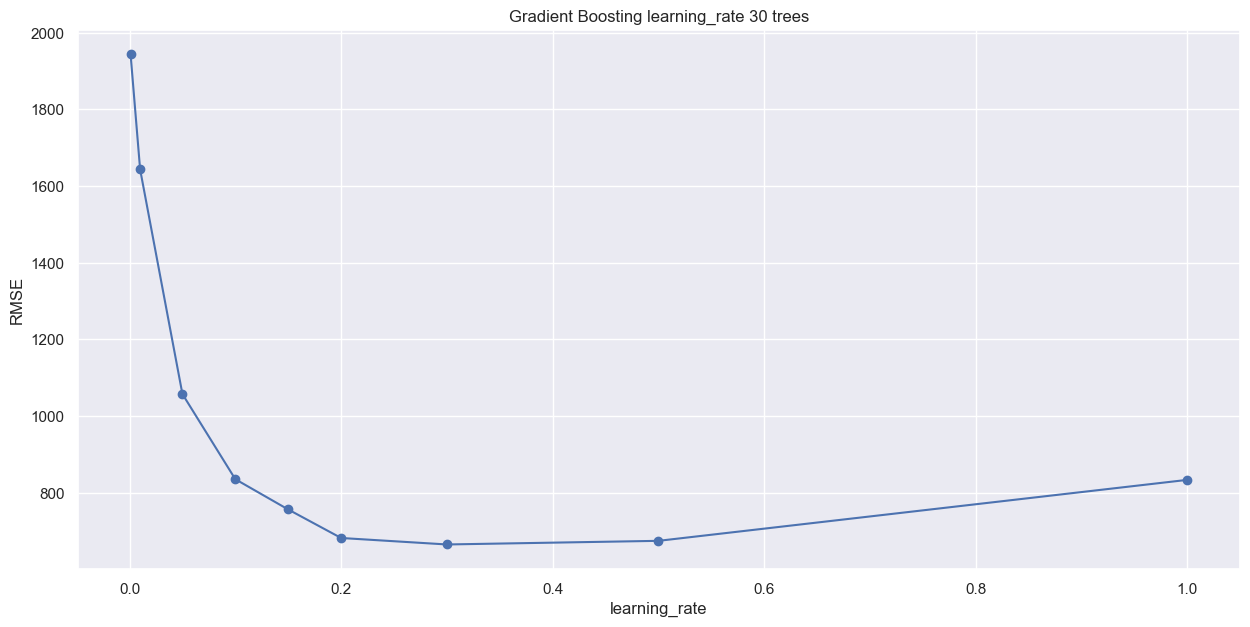

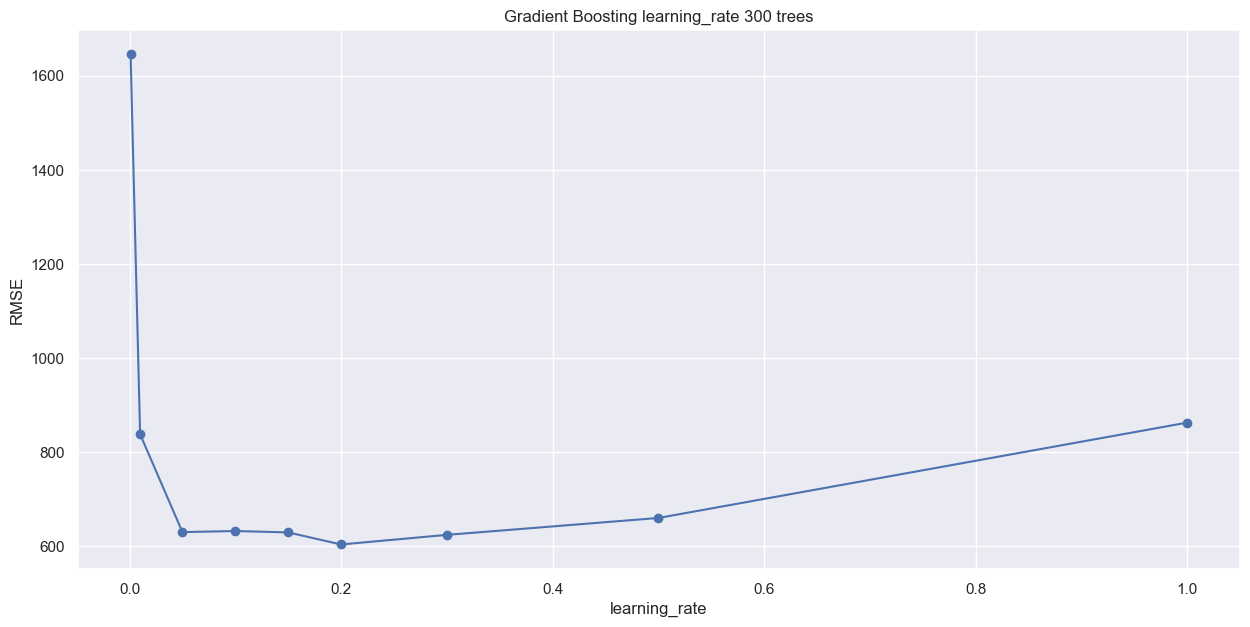

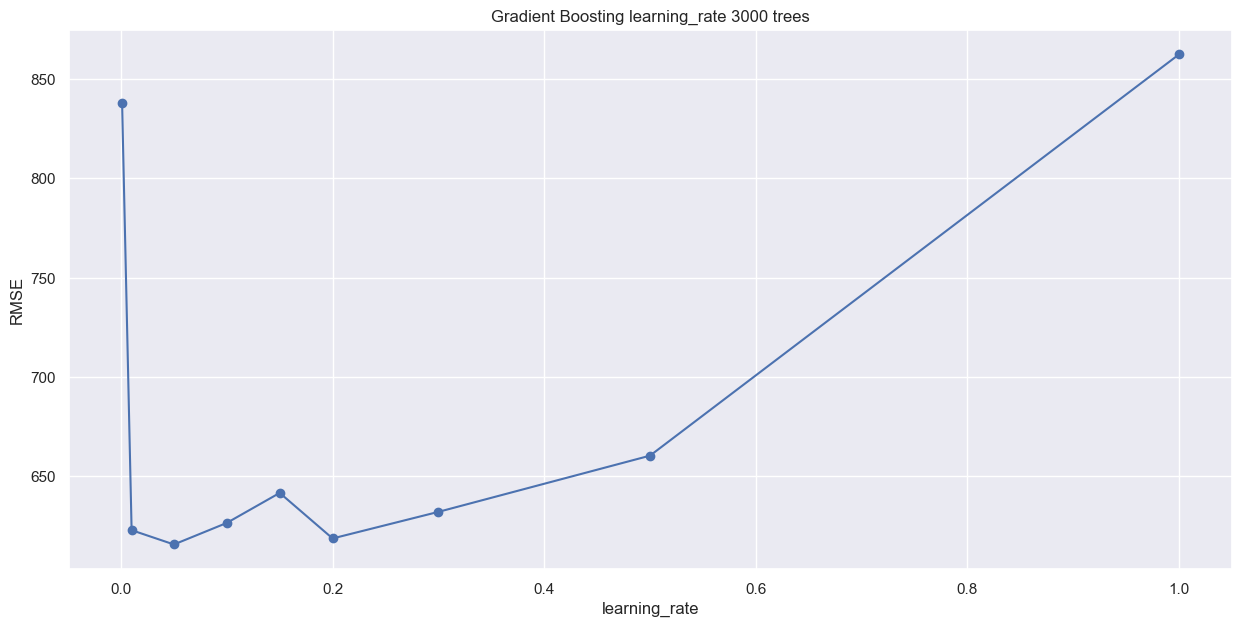

In [21]:
from sklearn.metrics import mean_squared_error

# 1. n_estimators 개수마다 for loop
for est in [30, 300, 3000]:
    rmse_scores = []
    # 2. 각 n_estimators마다 learning_rate 변화주기
    for value in learning_rate_values:
        gbr = GradientBoostingRegressor(max_depth=2, n_estimators=est, 
                                        random_state=42, learning_rate=value)
        gbr.fit(X_train, y_train)
        y_pred = gbr.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse_scores.append(rmse)
        
    plt.figure(figsize=(15,7))
    plt.plot(learning_rate_values, rmse_scores)
    plt.scatter(learning_rate_values, rmse_scores)
    plt.xlabel('learning_rate')
    plt.ylabel('RMSE')
    plt.title('Gradient Boosting learning_rate {} trees'.format(est))
    plt.show()

### 4.3.2. 속성들


#### init_
첫 번째 잔차를 계산하기 위한 초기 모델이 저장되어 있음

In [22]:
gbr.init_

DummyRegressor()

#### estimators_
앙상블에 추가된 트리가 저장되어 있음

In [23]:
len(gbr.estimators_)

3000

#### train_score_
부스팅 모델에 트리를 추가하면서 줄어드는 손실함수 값 저장되어 있음

### 4.3.3. validation_fraction & n_iter_no_change & tol
`validation_fraction`
+ 훈련 세트에서 검증 데이터 덜어낼 양
+ `default = 0.1`


`n_iter_no_change`
+ 반복 횟수 동안 검증 점수가 `tol(default 1e-4)` 만큼 향상되지 않으면 훈련을 종료
+ `default=None` 으로 조기종료 수행 안함

### 4.3.4. 기본 학습기
기본 학습기인 결정트리의 매개변수를 변화시킬 수 있음

#### max_depth

최대 깊이: None , 점수: 857.8796202032828
최대 깊이: 1 , 점수: 678.069869916268
최대 깊이: 2 , 점수: 631.0265307913979
최대 깊이: 3 , 점수: 652.3038233067876
최대 깊이: 4 , 점수: 572.0280967209038


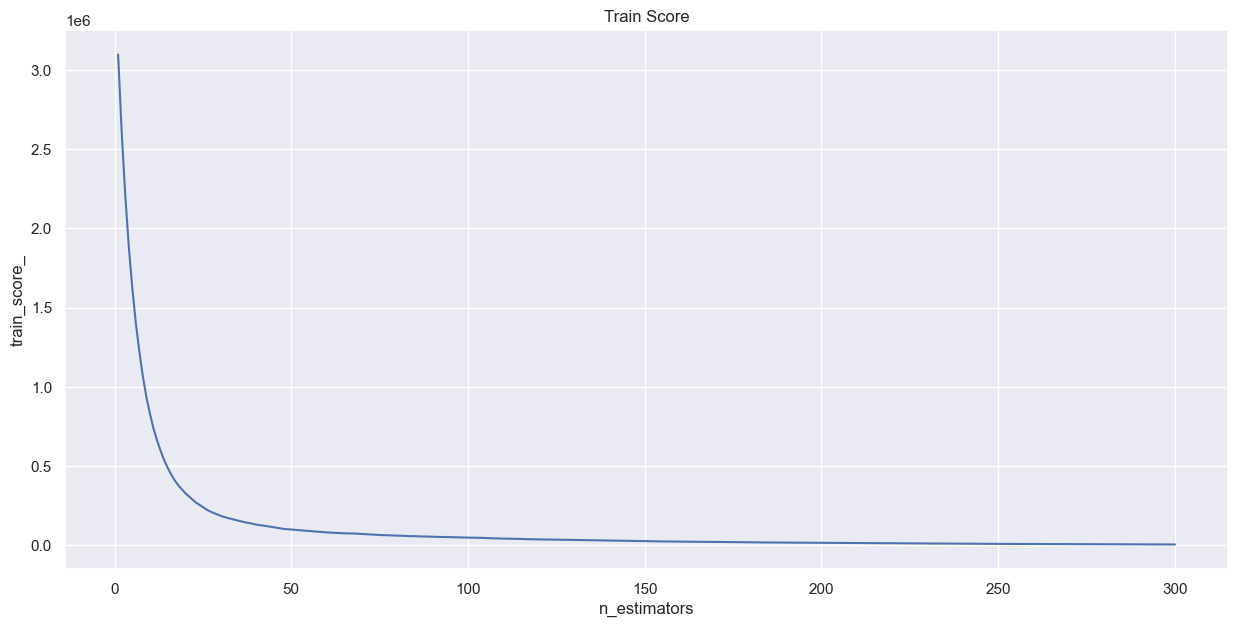

In [31]:
depths = [None, 1, 2, 3, 4]
n_estimators=300
for depth in depths:
    gbr = GradientBoostingRegressor(max_depth=depth, n_estimators=n_estimators, 
                                    random_state=42)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('최대 깊이:', depth, ', 점수:', rmse)
plt.figure(figsize=(15,7))
plt.plot(range(1, n_estimators+1), gbr.train_score_)
plt.xlabel('n_estimators')
plt.ylabel('train_score_')
plt.title('Train Score')
plt.show()

#### max_depth & 조기종료 옵션

최대 깊이: None , 점수: 875.7812764851641
최대 깊이: 1 , 점수: 685.7954881804477
최대 깊이: 2 , 점수: 649.9893947098984
최대 깊이: 3 , 점수: 675.674645952983
최대 깊이: 4 , 점수: 633.5385533730758


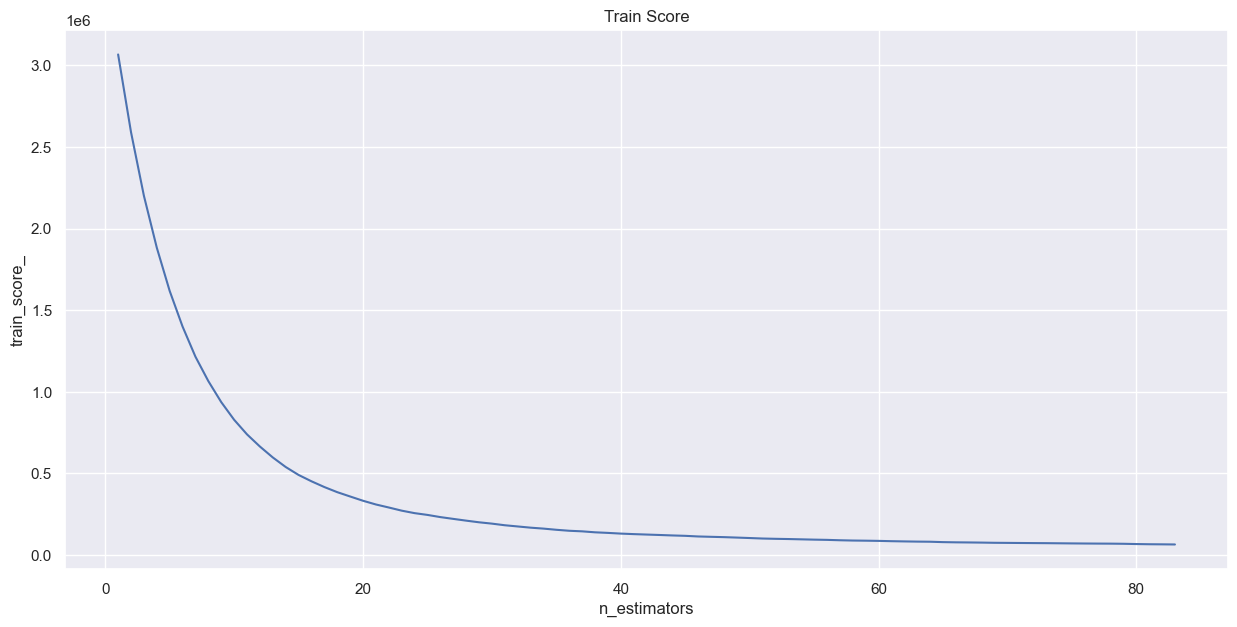

In [30]:
depths = [None, 1, 2, 3, 4]
n_estimators=300
for depth in depths:
    gbr = GradientBoostingRegressor(max_depth=depth, n_estimators=n_estimators, 
                                    random_state=42, n_iter_no_change = 10)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('최대 깊이:', depth, ', 점수:', rmse)

plt.figure(figsize=(15,7))
plt.plot(range(1, len(gbr.train_score_)+1), gbr.train_score_)
plt.xlabel('n_estimators')
plt.ylabel('train_score_')
plt.title('Train Score')
plt.show()

### 4.3.5. subsample & obb_improvement_

`subsample`
+ 기본 학습기에 사용될 샘플의 비율을 정함
+ `default=1`
+ 값이 1보다 작으면, 훈련할 때 샘플의 일부만 사용하게 됨(**확률적 그레디언트 부스팅**)

`obb_improvement_`
+ 속성으로, `subsample < 1` 인 경우, 남은 sample을 이용하여 `OOB 점수`를 계산할 수 있음

subsample: 1 , 점수: 652.3038233067876
subsample: 0.9 , 점수: 608.5485592319008
subsample: 0.8 , 점수: 600.9155680602979
subsample: 0.7 , 점수: 582.4611617020585
subsample: 0.6 , 점수: 587.5767181293851
subsample: 0.5 , 점수: 596.2195418730852


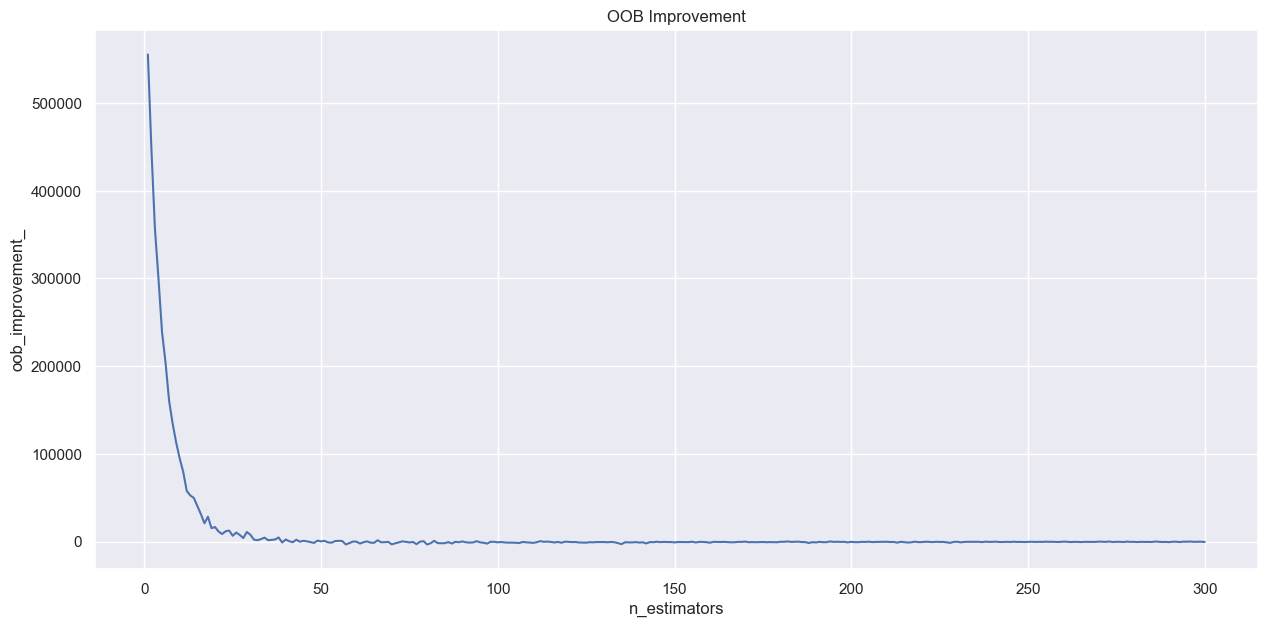

In [32]:
samples = [1, 0.9, 0.8, 0.7, 0.6, 0.5]
for sample in samples:
    gbr = GradientBoostingRegressor(max_depth=3, n_estimators=300, 
                                    subsample=sample, random_state=42)
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    rmse = MSE(y_test, y_pred)**0.5
    print('subsample:', sample, ', 점수:', rmse)
plt.figure(figsize=(15,7))
plt.plot(range(1, 301), gbr.oob_improvement_)
plt.xlabel('n_estimators')
plt.ylabel('oob_improvement_')
plt.title('OOB Improvement')
plt.show()

### 4.3.6 RandomizedSearchCV

In [37]:
# RandomizedSearchCV를 임포트합니다.
from sklearn.model_selection import RandomizedSearchCV
def randomcv(model, params, n_iter):

    # RandomizedSearchCV를 초기화합니다.
    rand_reg = RandomizedSearchCV(model, params, n_iter=n_iter,   # 10회 시도
                                  scoring='neg_mean_squared_error', 
                                  cv=5, n_jobs=-1, random_state=42)

    # X_train와 y_train로 rand_reg를 훈련합니다.
    rand_reg.fit(X_train, y_train)

    # 최상의 모델을 추출합니다.
    best_model = rand_reg.best_estimator_

    # 최상의 매개변수를 추출합니다.
    best_params = rand_reg.best_params_

    # 최상의 매개변수를 출력합니다.
    print("최상의 매개변수:", best_params)

    # 최상의 점수를 계산합니다.
    best_score = np.sqrt(-rand_reg.best_score_)

    # 최상의 점수를 출력합니다.
    print("훈련 점수: {:.3f}".format(best_score))

    # 테스트 세트에 대한 예측을 만듭니다.
    y_pred = best_model.predict(X_test)

    # 평균 제곱근 오차를 계산합니다.
    rmse_test = MSE(y_test, y_pred)**0.5

    # 평균 제곱근 오차를 출력합니다.
    print('테스트 세트 점수: {:.3f}'.format(rmse_test))




#### search 1

In [38]:
params = {'subsample':[0.7],
          'n_estimators':[300, 500, 1000,2000,3000],
          'learning_rate':[0.05, 0.075, 0.1],
         }
gbr = GradientBoostingRegressor(max_depth=3, random_state=42)
randomcv(gbr, params, 10)

최상의 매개변수: {'subsample': 0.7, 'n_estimators': 300, 'learning_rate': 0.05}
훈련 점수: 651.374
테스트 세트 점수: 578.710


#### search 2

In [40]:
params = {'subsample':[0.7],
          'n_estimators':[300, 500, 1000,2000,3000],
          'learning_rate':[0.01, 0.02, 0.05, 0.075],
         }
gbr = GradientBoostingRegressor(max_depth=3, random_state=42)
randomcv(gbr, params, 15)

최상의 매개변수: {'subsample': 0.7, 'n_estimators': 2000, 'learning_rate': 0.01}
훈련 점수: 638.628
테스트 세트 점수: 586.684


#### search 3

In [41]:
params = {'subsample':[0.7],
          'n_estimators':[1500, 1750 , 2000, 2250, 2500,4000],
          'learning_rate':[0.005, 0.0075, 0.01, 0.0125, 0.02],
         }
gbr = GradientBoostingRegressor(max_depth=3, random_state=42)
randomcv(gbr, params, 15)

최상의 매개변수: {'subsample': 0.7, 'n_estimators': 1750, 'learning_rate': 0.01}
훈련 점수: 638.640
테스트 세트 점수: 588.658


#### 최종모델

In [42]:
gbr = GradientBoostingRegressor(max_depth=3, n_estimators=2000, 
                                subsample=0.7, learning_rate=0.01, 
                                random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
MSE(y_test, y_pred)**0.5

586.6836197660022

### 4.3.7. XGBoost 와 비교

In [47]:
from xgboost import XGBRegressor
xg_reg = XGBRegressor(max_depth=3, n_estimators=2000, subsample=0.7, eta=0.01, random_state=42)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
print('테스트 점수 : ',MSE(y_test, y_pred)**0.5)
print('XGBoost를 GradientBoosting과 동일 파라미터로 훈련시, 더 빠르고 더 정확하다')

테스트 점수 :  576.455493333802
XGBoost를 GradientBoosting과 동일 파라미터로 훈련시, 더 빠르고 더 정확하다


## 4.4. GradientBoosting vs. XGBoost

### 4.4.1. 외계 행성 데이터셋 소개
2017년 캐글에 소개된 데이터 셋입니다. 별의 밝기에 대한 정보가 포함되어 있습니다.
+ 각 행은 하나의 별에 대한 정보
+ 각 열은 시간에 따라 밝기의 변화를 저장
+ label 열에는 별이 외계행성을 가지고 있으면 2, 아니면 1

별의 밝기가 주기적으로 달라질 때, 외계 행성이 이 별을 공전하고 있을 가능성이 있습니다. 외계 행성이 별의 앞을 지나갈 때 빛의 일부분을 가리고, 이로 인해 별의 밝기가 약간 감소된다고 가정한 것입니다.

### 4.4.2. 데이터 로드

In [52]:
df = pd.read_csv('exoplanets.csv')

# 데이터를 X와 y로 나눕니다.
X = df.iloc[:,1:]
y = df.iloc[:,0] - 1  # 외계행성 가지고 있으면 1, 아니면 0

# 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


In [51]:
df.isnull().sum().sum()

0

### 4.4.3. GradientBoosting vs. XGBoosting

In [64]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# accuracy_score를 임포트합니다.
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### 4.4.4. 시간측정


#### timeit
+ % : 라인에 대해서 실행
+ %% : 셀에 대해서 실행
+ -n : 반복에서 실행횟수
+ -r : 반복 횟수

In [54]:
%timeit -n 100 -r 3 sum(np.square(range(10000)))

1.1 ms ± 2.13 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [55]:
%%timeit -n 100 -r 3 
summing = 0
for i in range(10000):
    summing += i**2

2.34 ms ± 27.4 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [56]:
import time
start = time.time()

df.info()

end = time.time()
elapsed = end - start

print('\n실행 시간: ' + str(elapsed) + ' 초')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB

실행 시간: 0.19364452362060547 초


### 4.4.5. 속도 비교
모델 자체는 불균형자료를 잘 예측하지 못함

In [66]:
start = time.time()

gbr = GradientBoostingClassifier(n_estimators=100, 
                                 max_depth=2, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
score = accuracy_score(y_pred_gbr, y_test)
print('점수: ' + str(score))

print(classification_report(y_test, y_pred_gbr ))

end = time.time()
elapsed = end - start

print('실행 시간: ' + str(elapsed) + ' 초')

점수: 0.9874213836477987
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1261
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1272
   macro avg       0.50      0.50      0.50      1272
weighted avg       0.98      0.99      0.99      1272

실행 시간: 204.21732306480408 초


In [65]:
start = time.time()

# XGBRegressor를 초기화합니다.
xg_reg = XGBClassifier(n_estimators=100, max_depth=2, random_state=42)

# 훈련 세트에서 xg_reg를 훈련합니다.
xg_reg.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = xg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('점수: ' + str(score))
print(classification_report(y_test, y_pred ))


end = time.time()
elapsed = end - start

print('실행 시간: ' + str(elapsed) + ' 초')

점수: 0.9913522012578616
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1261
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1272
   macro avg       0.50      0.50      0.50      1272
weighted avg       0.98      0.99      0.99      1272

실행 시간: 6.536454200744629 초


In [67]:
y_test.value_counts()

0    1261
1      11
Name: LABEL, dtype: int64